In [1]:
from transformers import AutoModelForTokenClassification

# Will load LayoutLMv3ForTokenClassification
MODEL_PATH = "C:/Projects/IDP/watercare/model_output/23_11_03_03/checkpoint-150"
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH)

In [2]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained(MODEL_PATH, apply_ocr=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
# Convert pdf to images
from pdf2image import convert_from_path
from pathlib import Path

# Open a pdf file
images = convert_from_path(Path("C:/Projects/IDP/watercare/dataset/pdfs/23_10_25.pdf"), fmt="png")


In [4]:
import pytesseract
from idp.annotations.bbox_utils import normalize_box

def extract_text_from_image(image):
    img_width, img_height = image.size
    tesseract_output = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
    boxes = []
    texts = []
    for i, level_idx in enumerate(tesseract_output["level"]):
        if level_idx == 5:
            bbox = [tesseract_output["left"][i],
                    tesseract_output["top"][i],
                    tesseract_output["left"][i]+tesseract_output["width"][i],
                    tesseract_output["top"][i]+tesseract_output["height"][i]
            ]
            if not tesseract_output["text"][i].strip():
                continue
            bbox = normalize_box(bbox, img_width, img_height)
            texts.append(tesseract_output["text"][i])
            boxes.append(bbox)

    return (texts, boxes)

pages = len(images)
text_box_pairs = [extract_text_from_image(image) for image in images]
texts = [pair[0] for pair in text_box_pairs]
boxes = [pair[1] for pair in text_box_pairs]
page_indexes = [[index] * len(text_arr) for index, text_arr in enumerate(texts)]

In [6]:
def is_box_a_within_box_b(box_a, box_b):
    left_a, top_a, right_a, bottom_a = box_a
    left_b, top_b, right_b, bottom_b = box_b
    
    # Check if Box B contains box A
    return left_b<=left_a and top_b<=top_a and right_b>=right_a and bottom_b>=bottom_a
    
# Assume all pages have the same size
img_width, img_height = images[0].size

# HACK remove texts & boxes outside of Labelling area
def text_box_relevant(text_box_page):
    text, box, page = text_box_page
    
    if page == 0:
        outer_box = normalize_box((1298,828,1536,1550), img_width, img_height)
        return is_box_a_within_box_b(box, outer_box)
    elif page == 1:
        outer_box = normalize_box((139,119,827,1173), img_width, img_height)
        return is_box_a_within_box_b(box, outer_box)
    else:
        return False

out_texts = []
out_boxes = []

for page in range(pages):
    filtered_list = list(filter(text_box_relevant, list(zip(texts[page], boxes[page], page_indexes[page]))))
    results = [[text for text, box, page in filtered_list],[box for text, box, page in filtered_list]]
    temp_texts, temp_boxes = results
    out_texts.append(temp_texts)
    out_boxes.append(temp_boxes)
# texts, boxes = result

In [8]:
encoding = processor(images=images, text=out_texts, boxes=out_boxes, truncation=True, padding="max_length", return_tensors="pt")

In [9]:
# HACK - Trim tokens to match 512 
# encoding['input_ids'] = encoding['input_ids'][:,:512]
# encoding['attention_mask'] = encoding['attention_mask'][:,:512]
# encoding['bbox'] = encoding['bbox'][:,:512]

print(encoding['input_ids'][1])

tensor([    0, 10574, 23124,  1254, 24559,  1103,  7545,   731,  3201,  1132,
            4,   612,   449,   574,    68,   134,     4, 39101,    73,   330,
          574,    68,  4981,     4,  6405, 41768, 24159,   820,     4,  5067,
          449,   574,    68,   246,     4, 33981,    73,   330,   574,    68,
         5220,     4,  1225,    68, 22619,     4,  2546, 24559,  1254, 35616,
          117,     4,  1577,  1646,   250,  5606,   541,  2517,   111, 24559,
          675,  2357,   360,   152,  2600,   564,    12, 19144,    12,  1922,
          262,  4156,  5441, 16633,  1426,  2600,   820,    12, 37729,    12,
         1922,   262,   541, 30144, 24559,  1132,     4,   612,   330,   574,
         3201,  1132,     4,   612,   330,   574, 41768, 24159,   787,  5479,
            4,  1096,   207,   820,     4,  4718,   330,   574,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1, 

In [10]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

C:\Users\minhc\AppData\Local\pypoetry\Cache\virtualenvs\idp-1bLbv9p1-py3.10\lib\site-packages\transformers\modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [11]:
predictions = outputs.logits.argmax(-1).tolist()

In [12]:
model.config.id2label

{0: 'B-OTHER',
 1: 'B-BALANCE_STILL_OWING',
 2: 'B-WATER_CONSUMPTION',
 3: 'B-WASTEWATER_CONSUMPTION',
 4: 'B-WASTEWATER_FIXED',
 5: 'B-BALANCE_CURRENT_CHARGES',
 6: 'B-TOTAL_DUE',
 7: 'B-WATER_CONSUMPTION_DETAILS',
 8: 'B-WASTEWATER_CONSUMPTION_DETAILS',
 9: 'B-WASTEWATER_FIXED_DETAILS',
 10: 'B-THIS_READING',
 11: 'B-LAST_READING'}

In [13]:
from idp.annotations.bbox_utils import unnormalize_box, merge_box_extremes
from idp.annotations.annotation_utils import Classes, CLASS_TO_LABEL_MAP


token_boxes = encoding.bbox.tolist()
pages_input_ids = encoding['input_ids'].tolist()
PAD_ID = 1
# First token is a special token, ignore
pad_indexes = [page_input_ids.index(PAD_ID) for page_input_ids in encoding['input_ids'].tolist()]
true_predictions = [[model.config.id2label[pred] for pred in page_preds[1:pad_indexes[page_index]]] for page_index, page_preds in enumerate(predictions)]
true_boxes = [[unnormalize_box(box, img_width, img_height) for box in page_token_boxes[1:pad_indexes[page_index]]] for page_index,page_token_boxes in enumerate(token_boxes)]
true_texts = [[processor.tokenizer.decode([value]) for index, value in enumerate(page_input_ids[1:pad_indexes[page_index]])] for page_index,page_input_ids in enumerate(pages_input_ids)]



In [14]:

output = [{value: {'text':'','box':[]} for key,value in CLASS_TO_LABEL_MAP.items() if key != Classes.OTHER} for page in range(pages)]

for page_indx in range(pages):
    for key,value in CLASS_TO_LABEL_MAP.items():
        if key == Classes.OTHER:
            continue
        output[page_indx][value]['text'] = ''.join([ text for text, prediction, box in zip(true_texts[page_indx], true_predictions[page_indx], true_boxes[page_indx]) if (prediction == value and box != [0,0,0,0])])
        output[page_indx][value]['box'] = merge_box_extremes([box for text, prediction, box in zip(true_texts[page_indx], true_predictions[page_indx], true_boxes[page_indx]) if (prediction == value and box != [0,0,0,0])])

# #trim empty outputs
item_not_empty = lambda item : len(item[1]['text']) != 0
filtered_output = [dict(filter(item_not_empty, page_output.items())) for page_output in output]

In [15]:
filtered_output

[{'B-BALANCE_STILL_OWING': {'text': ' $ 137.14 cr',
   'box': [1385, 928, 1509, 949]},
  'B-WATER_CONSUMPTION': {'text': ' $ 57.94', 'box': [1398, 1167, 1477, 1188]},
  'B-WASTEWATER_CONSUMPTION': {'text': ' $79.11',
   'box': [1398, 1195, 1474, 1216]},
  'B-WASTEWATER_FIXED': {'text': ' $ 0.00', 'box': [1411, 1220, 1477, 1244]},
  'B-BALANCE_CURRENT_CHARGES': {'text': ' $ 137.05',
   'box': [1385, 1249, 1477, 1270]},
  'B-TOTAL_DUE': {'text': ' $ 0.09 cr', 'box': [1411, 1457, 1509, 1478]}},
 {'B-WATER_CONSUMPTION_DETAILS': {'text': ' Water 29.00 kL $1.998/kL $ 57.94',
   'box': [175, 254, 778, 285]},
  'B-WASTEWATER_CONSUMPTION_DETAILS': {'text': ' Wastewater 22.76 kL $3.476/kL $79.11',
   'box': [178, 278, 775, 311]},
  'B-THIS_READING': {'text': ' This reading 25-Oct-23 759 Estimate',
   'box': [178, 477, 798, 505]},
  'B-LAST_READING': {'text': ' Last reading 22-Sep-23 730 Actual',
   'box': [180, 505, 798, 526]}}]

In [16]:
from PIL import ImageDraw, ImageFont

# font = ImageFont.load_default()
font = ImageFont.truetype("arial.ttf", 20)

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'other':'pink','balance_still_owing':'red', 'water_consumption':'purple', 'wastewater_consumption':'green', 'wastewater_fixed':'orange', 'balance_current_charges':'violet',
              "total_due": "black",'water_consumption_details':'red','wastewater_consumption_details':'purple','wastewater_fixed_details':'green','this_reading':'grey','last_reading':'black'}

for indx, page_output in enumerate(filtered_output):
    draw = ImageDraw.Draw(images[indx])
    for item in page_output.items():
        predicted_label = iob_to_label(item[0]).lower()
        box = item[1]['box']
        draw.rectangle(box, outline=label2color[predicted_label])
#         draw.text((box[0] - 100, box[1]), text=f"{predicted_label}", fill=label2color[predicted_label], font=font)

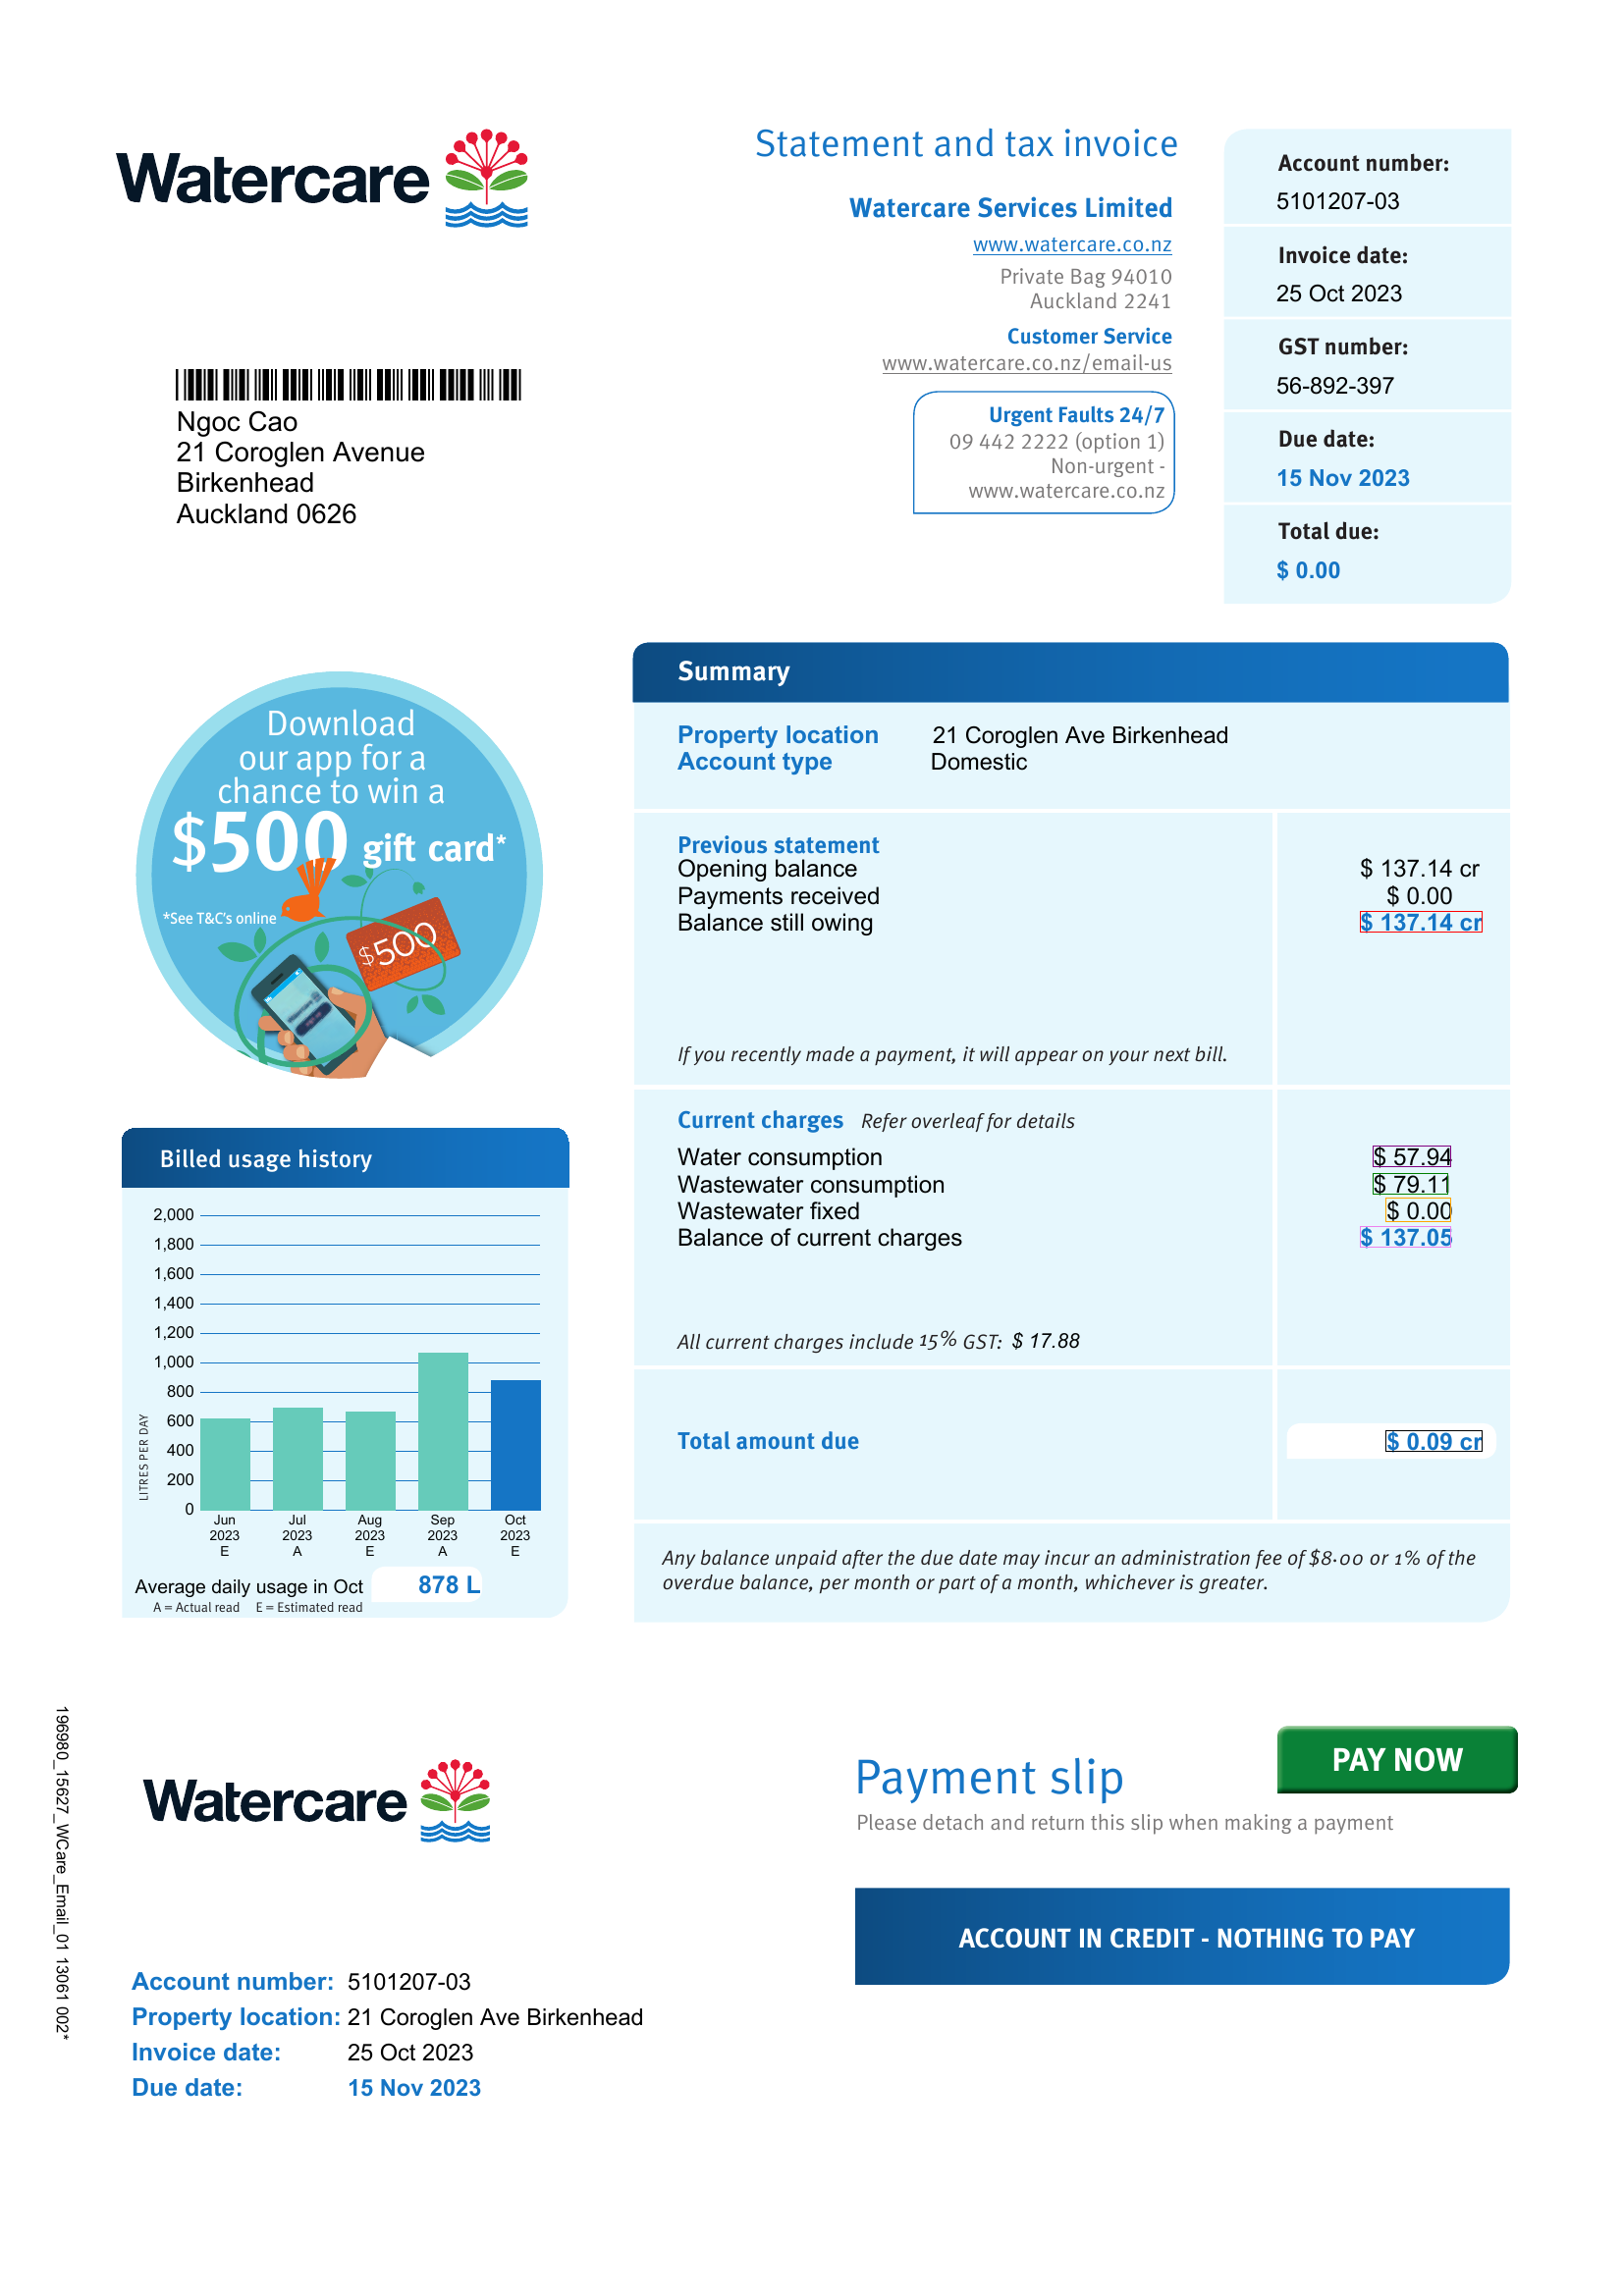

In [17]:
images[0]

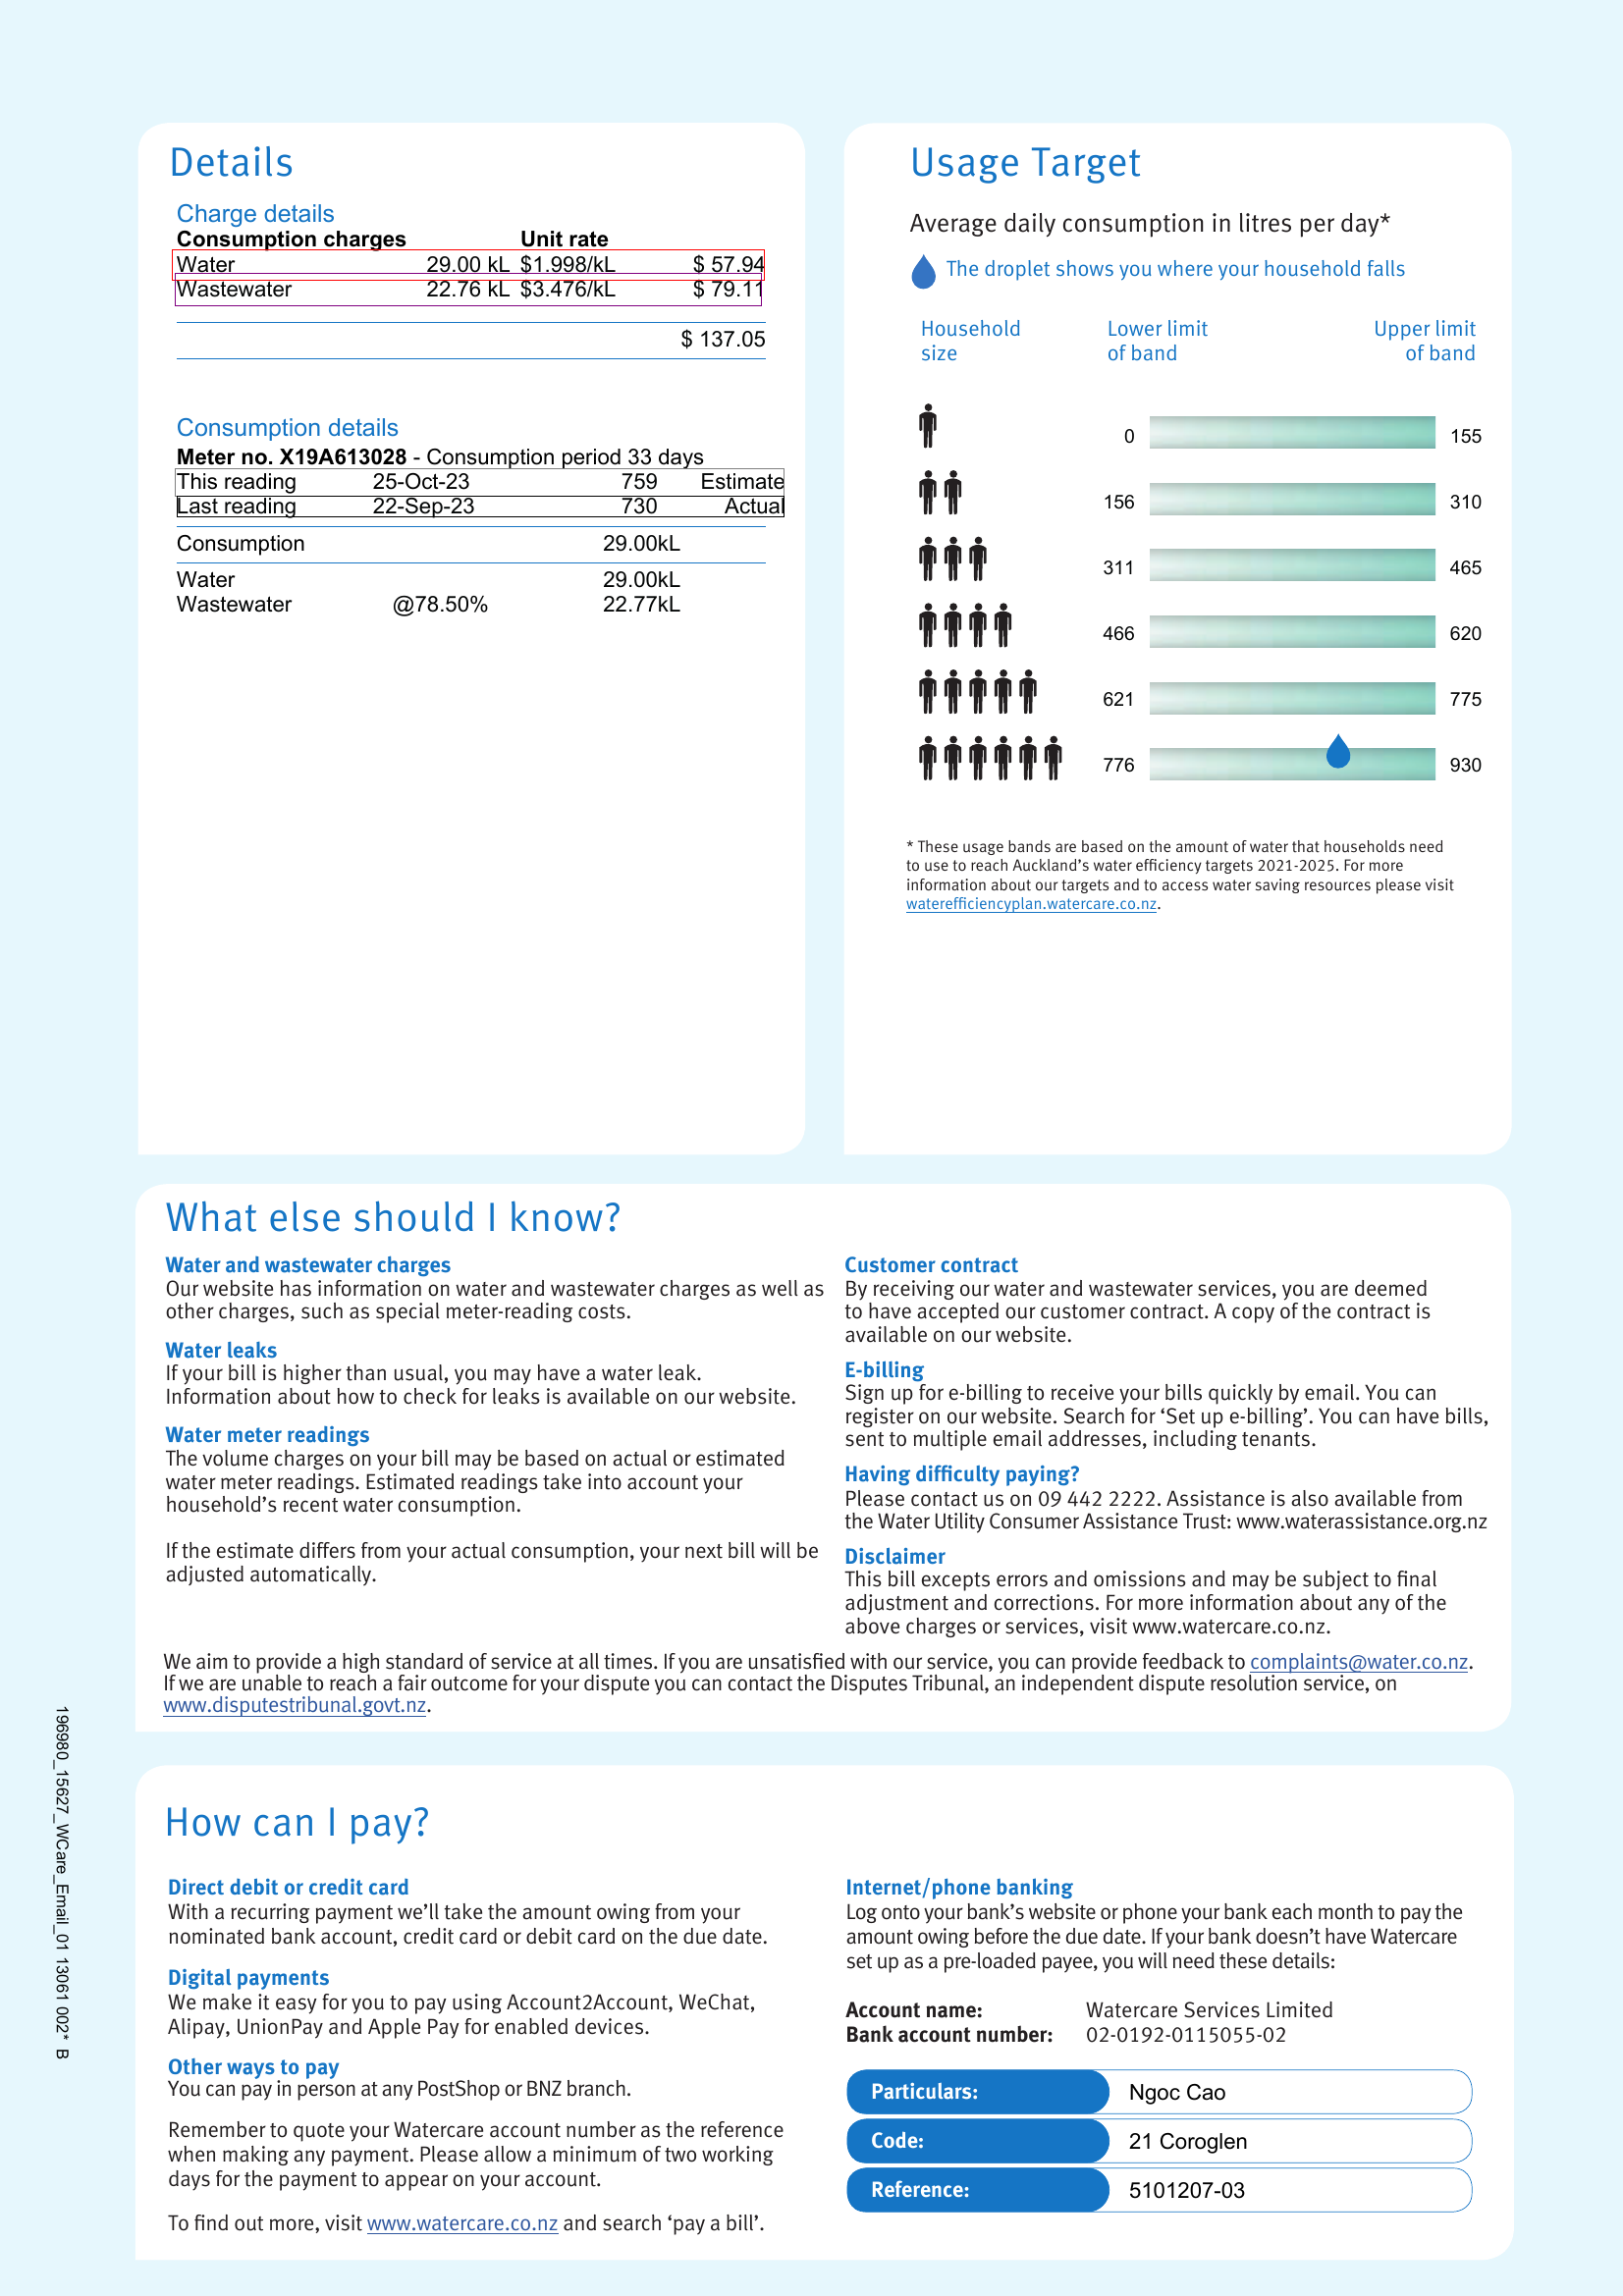

In [18]:
images[1]